# Определение возраста покупателей

## Описание исследования
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

## Цель исследования
Построить модель для определения возраста покупателя.

## Задачи исследования
Построить модель со значением метрики качества *MAE не более 8*.

## Исходные данные
Набор фотографий людей с указанием возраста.

## План исследования

***[Часть 1. Исследовательский анализ данных](#eda)***

***[Часть 2. Обучение модели](#ml)***

***[Часть 3. Анализ обученной модели](#ml)***

<a id='eda'></a>
## Исследовательский анализ данных

Импортирование нужных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


%matplotlib inline
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
plt.rc('figure', autolayout=True, figsize=(10, 7))
plt.rc('axes', titlesize=16, titlepad=10)

Поместим таблицу с названиями файлов в датафрейм.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим на основную информацию о датафрейме.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет не очень большой, но для нашей задачи данных должно хватить.

Посмотрим на статистические данные о возрасте людей на фото.

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Среднее и медиана распределения возраста достаточно близки, около 30 лет. Есть возраста от 1 года до 100 лет.

In [5]:
print(f"Количество одинаковых названий файлов в таблице: {labels['file_name'].duplicated().sum()}")

Количество одинаковых названий файлов в таблице: 0


Проверим совпадает ли количество изображений и количество лейблов в таблице

In [6]:
!ls /datasets/faces/final_files | wc -l

7591


In [7]:
assert labels.shape[0] == 7591

Изображений столько же, сколько и лейблов

Посмотрим на примеры фотографий

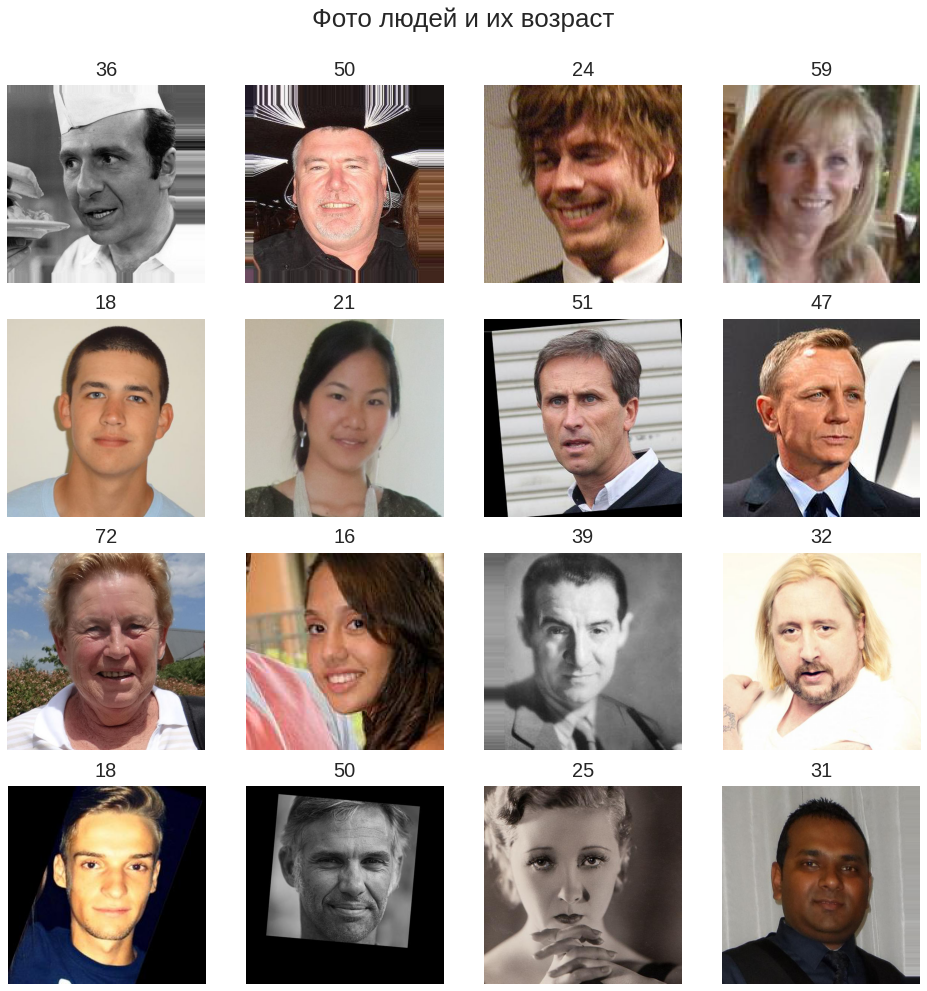

In [8]:
fig, axs = plt.subplots(4, 4)
fig.suptitle('Фото людей и их возраст\n', fontsize=26)
fig.set_size_inches(14, 14)
filenames = labels.sample(16)['file_name'].to_numpy().reshape(4, 4)
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(mpimg.imread(f'/datasets/faces/final_files/{filenames[i][j]}'))
        axs[i][j].set_title(int(labels[labels['file_name'] == filenames[i][j]]['real_age']), fontsize=20)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
plt.tight_layout();

С изображениями уже проведены определённые манипуляции: сразу заметны небольшие повороты и смещения. Часть изображений чёрно-белая.

Посмотрим на распределение возраста

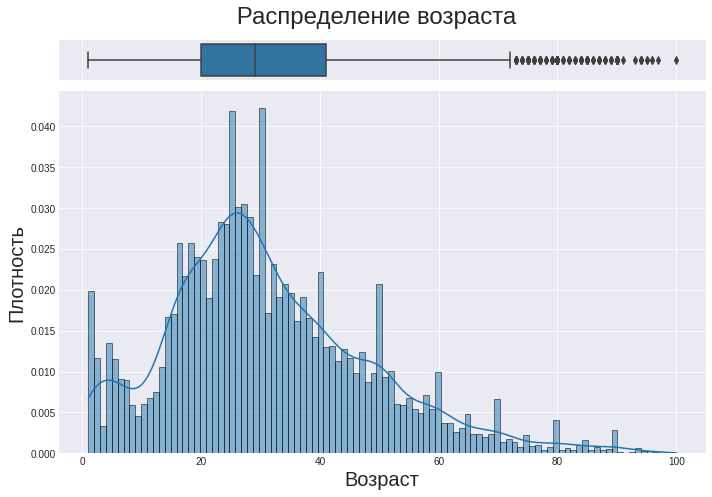

In [9]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
fig.suptitle(' ' * 6 + 'Распределение возраста', fontsize=24)

sns.boxplot(labels["real_age"], ax=ax_box)
sns.histplot(labels["real_age"], bins=100, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[], xlabel='')
plt.ylabel('Плотность', fontsize=20)
plt.xlabel('Возраст', fontsize=20);

Мода распределения приходится на людей 20-30 лет, изображений людей старше 70 лет в датасете мало.

Может быть интересным, что фото младенцев больше, чем фотографий детей других возрастов.

*Выводы по исследовательскому анализу:*
- датасет сложно назвать большим, но для нашей задачи данных должно хватить
- есть возраста от 1 года до 100 лет
- с изображениями уже проведены определённые манипуляции: сразу заметны небольшие повороты и смещения
- часть изображений чёрно-белая
- среднее и медиана распределения возраста достаточно близки, около 30 лет
- изображений людей старше 70 лет в датасете мало

<a id='ml'></a>
## Обучение модели

Напишем функцию для создания загрузчиков данных

```python
#создание загрузчика тренировочных данных
def load_train(path):
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                horizontal_flip=True, #добавим аугментации для повышения робастности модели
                                brightness_range=[0.7, 1.0],
                                validation_split=0.25)
    train_gen_flow = train_gen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files/',
        subset='training',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=42)
    return train_gen_flow


#создание загрузчика валидационных данных
def load_test(path):
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.25)
    test_gen_flow = test_gen.flow_from_dataframe(
        dataframe=pd.read_csv(f'{path}/labels.csv'),
        directory=f'{path}/final_files/',
        subset='validation',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=42
    )
    return test_gen_flow
```

Напишем функцию для создания модели

```python
def create_model(input_shape):
    #дообучим ResNet50, изначально обученную на imagenet
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential([
        backbone,
        Dropout(0.1), #чтобы снизить переобучение добавим слой Dropout
        GlobalAveragePooling2D(),
        Dense(1, activation='relu') #целевая переменная – возраст, функция активации ReLU уберёт
                                    #отрицательные значения
    ])
    model.compile(optimizer=Adam(lr=1e-4), loss='mae',
                  metrics=['mae'])
    return model
```

Напишем функцию для тренировки модели

```python
def train_model(model, train_data, test_data, batch_size=None, epochs=30,
               steps_per_epoch=None, validation_steps=None):
    def scheduler(epoch, lr): #на каждой 10-й эпохе будем уменьшать learning rate в 10 раз
        if epoch != 0 and epoch % 10 == 0:
            return lr / 10
        else:
            return lr

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              callbacks=[LearningRateScheduler(scheduler),
                         EarlyStopping(monitor="val_loss", patience=3)], #если функция потерь на валидации 
                                                              #не будет изменяться в лучшую сторону
                                                              #в течение 3-х эпох, то обучение прекратится
              shuffle=True)
    return model
```

***Модель была обучена на облачном сервере***

Информации об обучении:

<a id='fin'></a>
## Анализ обученной модели

Посмотрим на графики изменения функции потерь на каждой эпохе

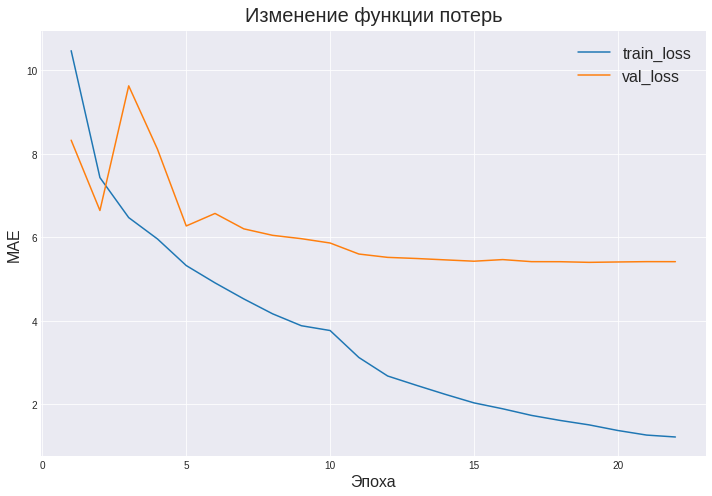

In [10]:
train_loss = [10.4697, 7.4315, 6.4743, 5.9628, 5.3260, 4.9115, 4.5274, 4.1711, 3.8857, 3.7706, 
              3.1248, 2.6819, 2.4590, 2.2430, 2.0384, 1.8965, 1.7384, 1.6175, 1.5119, 1.3774, 1.2675, 1.2218]
val_loss = [8.3275, 6.6448, 9.6284, 8.1112, 6.2742, 6.5736, 6.2050, 6.0498, 5.9695, 5.8658, 5.6019,
           5.5220, 5.4951, 5.4623, 5.4302, 5.4689, 5.4194, 5.4182, 5.4027, 5.4119, 5.4198, 5.4191]

plt.plot(range(1, 23), train_loss, label='train_loss')
plt.plot(range(1, 23), val_loss, label='val_loss')
plt.title('Изменение функции потерь', fontsize=20)
plt.xlabel('Эпоха', fontsize=16)
plt.ylabel('MAE', fontsize=16)
plt.legend(fontsize=16);

В результате получилось добится средней абсолютной ошибки 5.4 на валидационной выборке. Для данного датасета это считается крайне хорошим результатом.

Полученной в данном исследовании точности достаточно для определения возрастной группы покупателей, что поможет более осмысленно рекомендовать нужные людям покупки и контролировать добросовестность кассиров при продаже алкоголя.

Для повышения точности в дальнейшем стоит рассмореть возможность расширения датасета, замены задачи на классификацию (предсказание возрастной группы) или использования других моделей.